In [1]:
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm

from src.HNN.hnn import train_hnn, simulate_hnn, compute_derivatives_torch 
from src.HNN.custom_emlp_hnn import *
from src.HNN.nbody_dataset import * 

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="torch.utils._pytree._register_pytree_node is deprecated")




/mnt/d_disk/ch20b065/.conda/envs/liegan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# generate 2 body dataset 
# data_dict = generate_two_body_dataset(
#         save_path='./data/two_body_dataset.pkl',
#         num_trajectories=20,  # Smaller number for quick testing
#         t_span=(0, 10),
#         num_steps=100,
#         G=1.0,
#         m1=1.0,
#         m2=1.0,
#         min_radius=1.5,
#         max_radius=3.0,
#         eccentricity_range=(0.0, 0.5),
#         orbit_noise=0.01,
#         random_seed=42
#     )

In [3]:
# Load the 2 body dataset 
with open('Data/two_body_dataset.pkl','rb') as f:
    data_dict = pickle.load(f)

print('Dataset Keys:',data_dict.keys())

metadata = data_dict['metadata']
print('Metadata:',metadata)

Dataset Keys: dict_keys(['coords', 'test_coords', 'energies', 'test_energies', 'angular_momenta', 'test_angular_momenta', 'metadata'])
Metadata: {'G': 1.0, 'm1': 1.0, 'm2': 1.0, 't_span': (0, 10), 'num_steps': 100, 't_eval': [0.0, 0.10101010101010101, 0.20202020202020202, 0.30303030303030304, 0.40404040404040403, 0.5050505050505051, 0.6060606060606061, 0.7070707070707071, 0.8080808080808081, 0.9090909090909091, 1.0101010101010102, 1.1111111111111112, 1.2121212121212122, 1.3131313131313131, 1.4141414141414141, 1.5151515151515151, 1.6161616161616161, 1.7171717171717171, 1.8181818181818181, 1.9191919191919191, 2.0202020202020203, 2.121212121212121, 2.2222222222222223, 2.323232323232323, 2.4242424242424243, 2.525252525252525, 2.6262626262626263, 2.727272727272727, 2.8282828282828283, 2.929292929292929, 3.0303030303030303, 3.131313131313131, 3.2323232323232323, 3.3333333333333335, 3.4343434343434343, 3.5353535353535355, 3.6363636363636362, 3.7373737373737375, 3.8383838383838382, 3.939393939

In [4]:
coords = data_dict['coords']
test_coords = data_dict['test_coords']
dt = (metadata['t_span'][1]-metadata['t_span'][0])/metadata['timesteps']


In [5]:
q = torch.tensor(coords[:,:,:4])
p = torch.tensor(coords[:,:,4:]) 

q_test = torch.tensor(test_coords[:, :, :4], dtype=torch.float32)
p_test = torch.tensor(test_coords[:, :, 4:], dtype=torch.float32)

In [6]:
print(f"Position (q) shape: {q.shape}")
print(f"Momentum (p) shape: {p.shape}")
print(f"Test position shape: {q_test.shape}")
print(f"Test momentum shape: {p_test.shape}")

Position (q) shape: torch.Size([1600, 100, 4])
Momentum (p) shape: torch.Size([1600, 100, 4])
Test position shape: torch.Size([400, 100, 4])
Test momentum shape: torch.Size([400, 100, 4])


In [7]:
# Compute derivatives for training
print("Computing derivatives...")
dq_dt, dp_dt = compute_derivatives_torch(q, p, dt)
dq_dt_test, dp_dt_test = compute_derivatives_torch(q_test, p_test, dt)

print(f"Position derivative shape: {dq_dt.shape}")
print(f"Momentum derivative shape: {dp_dt.shape}")


Computing derivatives...
Position derivative shape: torch.Size([1600, 100, 4])
Momentum derivative shape: torch.Size([1600, 100, 4])


In [8]:
if len(q.shape) == 2:
    states = torch.stack([q.reshape(-1), p.reshape(-1)], dim=1)
    test_states = torch.stack([q_test.reshape(-1), p_test.reshape(-1)], dim=1)


    true_derivatives = torch.stack([dq_dt.reshape(-1), dp_dt.reshape(-1)], dim=1)
    test_true_derivatives = torch.stack([dq_dt_test.reshape(-1), dp_dt_test.reshape(-1)], dim=1)
elif len(q.shape) == 3:
    states = torch.stack([q.reshape(-1,q.shape[-1]), p.reshape(-1,p.shape[-1])], dim=1)
    test_states = torch.stack([q_test.reshape(-1,q_test.shape[-1]), p_test.reshape(-1,p_test.shape[-1])], dim=1)
    states,test_states = states.reshape(len(states),-1), test_states.reshape(len(test_states),-1)

    true_derivatives = torch.stack([dq_dt.reshape(-1, q.shape[-1]), dp_dt.reshape(-1, p.shape[-1])], dim=1)
    test_true_derivatives = torch.stack([dq_dt_test.reshape(-1, q_test.shape[-1]), dp_dt_test.reshape(-1, p_test.shape[-1])], dim=1)
    true_derivatives, test_true_derivatives = true_derivatives.reshape(len(true_derivatives),-1), test_true_derivatives.reshape(len(test_true_derivatives),-1)

In [9]:
print(f"Training states shape: {states.shape}")
print(f"Training derivatives shape: {true_derivatives.shape}")
print(f"Test states shape: {test_states.shape}")
print(f"Test derivatives shape: {test_true_derivatives.shape}")

# Verify data integrity
print("\nVerifying data integrity:")
print(f"Any NaN in states: {torch.isnan(states).any()}")
print(f"Any Inf in states: {torch.isinf(states).any()}")
print(f"Any NaN in derivatives: {torch.isnan(true_derivatives).any()}")
print(f"Any Inf in derivatives: {torch.isinf(true_derivatives).any()}")

# Enable gradients
states.requires_grad = True
test_states.requires_grad = True

Training states shape: torch.Size([160000, 8])
Training derivatives shape: torch.Size([160000, 8])
Test states shape: torch.Size([40000, 8])
Test derivatives shape: torch.Size([40000, 8])

Verifying data integrity:
Any NaN in states: False
Any Inf in states: False
Any NaN in derivatives: False
Any Inf in derivatives: False


In [10]:
states = states.to(torch.float32)
test_states = test_states.to(torch.float32)

true_derivatives = true_derivatives.to(torch.float32)
test_true_derivatives = test_true_derivatives.to(torch.float32)

In [11]:
train_size = 2000
test_size = 400

# Sample accordingly
train_indices = np.random.choice(len(states), size=train_size, replace=False)
test_indices = np.random.choice(len(test_states), size=test_size, replace=False)

# train_dataset = Subset(train_dataset,train_indices)
# test_dataset = Subset(test_dataset,test_indices) 

states = states[train_indices]
true_derivatives = true_derivatives[train_indices] 

test_states = test_states[test_indices] 
test_true_derivatives = test_true_derivatives[test_indices]

In [12]:
# Initializing the symmetry groups 
n_dim = 8
n_channel = 1

lie_algebra = get_generators(n_dim,n_channel,'saved_model/LieGAN/two_body/two_body_generator_99.pt','traj_pred')
G = CustomGroup(n_dim,lie_algebra) 

None


In [13]:
print("\nTraining HNN model...")
batch_size = 64
epochs = 200
lr = 1e-3  # Lowered learning rate for better stability
input_dim = n_dim  
hidden_dim = 256  # Increased hidden dimension for more capacity

model_hnn, stats_hnn = train_hnn(
    states, true_derivatives, 
    test_states, test_true_derivatives,
    batch_size, epochs, lr, 
    input_dim, hidden_dim,
    output_dim=1  # IMPORTANT: Hamiltonian should be a scalar function
) 


Training HNN model...
Using Device : cuda:3
Starting training: 200 epochs
Epoch 1/200, Train Loss: 0.133072, Test Loss: 0.128228
Epoch 11/200, Train Loss: 0.008411, Test Loss: 0.008793
Epoch 21/200, Train Loss: 0.003997, Test Loss: 0.004546
Epoch 31/200, Train Loss: 0.002695, Test Loss: 0.003172
Epoch 41/200, Train Loss: 0.002358, Test Loss: 0.002886
Epoch 51/200, Train Loss: 0.002002, Test Loss: 0.002711
Epoch 61/200, Train Loss: 0.002062, Test Loss: 0.002464
Epoch 71/200, Train Loss: 0.001922, Test Loss: 0.002745
Epoch 81/200, Train Loss: 0.001751, Test Loss: 0.002255
Epoch 91/200, Train Loss: 0.001522, Test Loss: 0.001840
Epoch 101/200, Train Loss: 0.001694, Test Loss: 0.002058
Epoch 111/200, Train Loss: 0.001465, Test Loss: 0.001774
Epoch 121/200, Train Loss: 0.001413, Test Loss: 0.001734
Epoch 131/200, Train Loss: 0.001401, Test Loss: 0.001757
Epoch 141/200, Train Loss: 0.001468, Test Loss: 0.001742
Epoch 151/200, Train Loss: 0.001378, Test Loss: 0.001703
Epoch 161/200, Train Los

In [14]:
print("\nTraining EMLP HNN model using discovered symmetries...")

model_hnn_emlp, stats_hnn_emlp = train_hnn_emlp(
    G, states, true_derivatives, 
    test_states, test_true_derivatives,
    batch_size, 200, lr, 
    input_dim, rep = 1, hidden_dim=256,
    num_layers= 3, debug=False
)



Training EMLP HNN model using discovered symmetries...
Starting training: 200 epochs


  1%|          | 2/200 [00:19<26:39,  8.08s/it]  

Epoch 1/200 | Train Loss: 0.136971 | Test Loss: 0.135319 | Grad Norm: 0.000000


  6%|▌         | 12/200 [00:20<00:44,  4.19it/s]

Epoch 11/200 | Train Loss: 0.134711 | Test Loss: 0.135319 | Grad Norm: 0.000000


 11%|█         | 22/200 [00:22<00:22,  7.76it/s]

Epoch 21/200 | Train Loss: 0.136842 | Test Loss: 0.135319 | Grad Norm: 0.000000


 16%|█▌        | 32/200 [00:23<00:21,  7.77it/s]

Epoch 31/200 | Train Loss: 0.134839 | Test Loss: 0.135319 | Grad Norm: 0.000000


 21%|██        | 42/200 [00:24<00:20,  7.60it/s]

Epoch 41/200 | Train Loss: 0.133894 | Test Loss: 0.135319 | Grad Norm: 0.000000


 26%|██▌       | 52/200 [00:25<00:18,  7.84it/s]

Epoch 51/200 | Train Loss: 0.134972 | Test Loss: 0.135319 | Grad Norm: 0.000000


 31%|███       | 62/200 [00:27<00:17,  7.81it/s]

Epoch 61/200 | Train Loss: 0.136436 | Test Loss: 0.135319 | Grad Norm: 0.000000


 36%|███▌      | 72/200 [00:28<00:15,  8.01it/s]

Epoch 71/200 | Train Loss: 0.136307 | Test Loss: 0.135319 | Grad Norm: 0.000000


 41%|████      | 82/200 [00:29<00:14,  7.93it/s]

Epoch 81/200 | Train Loss: 0.134387 | Test Loss: 0.135319 | Grad Norm: 0.000000


 46%|████▌     | 92/200 [00:30<00:13,  7.78it/s]

Epoch 91/200 | Train Loss: 0.134473 | Test Loss: 0.135319 | Grad Norm: 0.000000


 51%|█████     | 102/200 [00:32<00:12,  8.01it/s]

Epoch 101/200 | Train Loss: 0.134527 | Test Loss: 0.135319 | Grad Norm: 0.000000


 56%|█████▌    | 112/200 [00:33<00:12,  7.28it/s]

Epoch 111/200 | Train Loss: 0.134371 | Test Loss: 0.135319 | Grad Norm: 0.000000


 61%|██████    | 122/200 [00:34<00:10,  7.17it/s]

Epoch 121/200 | Train Loss: 0.134322 | Test Loss: 0.135319 | Grad Norm: 0.000000


 66%|██████▌   | 132/200 [00:36<00:08,  7.86it/s]

Epoch 131/200 | Train Loss: 0.136147 | Test Loss: 0.135319 | Grad Norm: 0.000000


 71%|███████   | 142/200 [00:37<00:07,  7.96it/s]

Epoch 141/200 | Train Loss: 0.134317 | Test Loss: 0.135319 | Grad Norm: 0.000000


 76%|███████▌  | 152/200 [00:38<00:06,  7.83it/s]

Epoch 151/200 | Train Loss: 0.136624 | Test Loss: 0.135319 | Grad Norm: 0.000000


 81%|████████  | 162/200 [00:40<00:04,  8.11it/s]

Epoch 161/200 | Train Loss: 0.133927 | Test Loss: 0.135319 | Grad Norm: 0.000000


 86%|████████▌ | 172/200 [00:41<00:03,  8.05it/s]

Epoch 171/200 | Train Loss: 0.134252 | Test Loss: 0.135319 | Grad Norm: 0.000000


 91%|█████████ | 182/200 [00:42<00:02,  7.97it/s]

Epoch 181/200 | Train Loss: 0.137615 | Test Loss: 0.135319 | Grad Norm: 0.000000


 96%|█████████▌| 192/200 [00:43<00:00,  8.11it/s]

Epoch 191/200 | Train Loss: 0.136061 | Test Loss: 0.135319 | Grad Norm: 0.000000


100%|██████████| 200/200 [00:44<00:00,  4.47it/s]

Epoch 200/200 | Train Loss: 0.134105 | Test Loss: 0.135319 | Grad Norm: 0.000000


In [15]:
print("\nTraining EMLP HNN model using true symmetries...")

from emlp.groups import SO, DirectProduct 

Gt = SO(2) 

model_hnn_emlp_t, stats_hnn_emlp_t = train_hnn_emlp(
    Gt, states, true_derivatives, 
    test_states, test_true_derivatives,
    batch_size, 200, lr, 
    input_dim, rep = 4, hidden_dim=256,
    num_layers= 3, debug=False
)



Training EMLP HNN model using true symmetries...
Starting training: 200 epochs


  1%|          | 2/200 [00:33<46:10, 13.99s/it]  

Epoch 1/200 | Train Loss: 0.135557 | Test Loss: 0.134966 | Grad Norm: 0.002389


  6%|▌         | 12/200 [00:35<01:08,  2.75it/s]

Epoch 11/200 | Train Loss: 0.002728 | Test Loss: 0.002432 | Grad Norm: 0.034917


 11%|█         | 22/200 [00:37<00:29,  6.10it/s]

Epoch 21/200 | Train Loss: 0.000399 | Test Loss: 0.000435 | Grad Norm: 0.017087


 16%|█▌        | 32/200 [00:38<00:25,  6.50it/s]

Epoch 31/200 | Train Loss: 0.000462 | Test Loss: 0.000327 | Grad Norm: 0.038431


 21%|██        | 42/200 [00:40<00:24,  6.48it/s]

Epoch 41/200 | Train Loss: 0.000189 | Test Loss: 0.000116 | Grad Norm: 0.019879


 26%|██▌       | 52/200 [00:41<00:23,  6.26it/s]

Epoch 51/200 | Train Loss: 0.000094 | Test Loss: 0.000073 | Grad Norm: 0.011257


 31%|███       | 62/200 [00:43<00:22,  6.27it/s]

Epoch 61/200 | Train Loss: 0.000087 | Test Loss: 0.000068 | Grad Norm: 0.008791


 36%|███▌      | 72/200 [00:44<00:19,  6.44it/s]

Epoch 71/200 | Train Loss: 0.000066 | Test Loss: 0.000055 | Grad Norm: 0.007547


 41%|████      | 82/200 [00:46<00:19,  5.95it/s]

Epoch 81/200 | Train Loss: 0.000051 | Test Loss: 0.000042 | Grad Norm: 0.005454


 46%|████▌     | 92/200 [00:48<00:17,  6.11it/s]

Epoch 91/200 | Train Loss: 0.000064 | Test Loss: 0.000066 | Grad Norm: 0.008718


 51%|█████     | 102/200 [00:49<00:15,  6.35it/s]

Epoch 101/200 | Train Loss: 0.000044 | Test Loss: 0.000059 | Grad Norm: 0.004943


 56%|█████▌    | 112/200 [00:51<00:13,  6.39it/s]

Epoch 111/200 | Train Loss: 0.000046 | Test Loss: 0.000034 | Grad Norm: 0.004876


 61%|██████    | 122/200 [00:52<00:11,  6.50it/s]

Epoch 121/200 | Train Loss: 0.000054 | Test Loss: 0.000035 | Grad Norm: 0.005883


 66%|██████▌   | 132/200 [00:54<00:10,  6.22it/s]

Epoch 131/200 | Train Loss: 0.000068 | Test Loss: 0.000053 | Grad Norm: 0.008801


 71%|███████   | 142/200 [00:56<00:09,  6.35it/s]

Epoch 141/200 | Train Loss: 0.000034 | Test Loss: 0.000029 | Grad Norm: 0.003657


 76%|███████▌  | 152/200 [00:57<00:07,  6.43it/s]

Epoch 151/200 | Train Loss: 0.000030 | Test Loss: 0.000025 | Grad Norm: 0.003575


 81%|████████  | 162/200 [00:59<00:05,  6.36it/s]

Epoch 161/200 | Train Loss: 0.000036 | Test Loss: 0.000237 | Grad Norm: 0.005449


 86%|████████▌ | 172/200 [01:00<00:04,  6.38it/s]

Epoch 171/200 | Train Loss: 0.000024 | Test Loss: 0.000033 | Grad Norm: 0.002210


 91%|█████████ | 182/200 [01:02<00:02,  6.42it/s]

Epoch 181/200 | Train Loss: 0.000025 | Test Loss: 0.000024 | Grad Norm: 0.003605


 96%|█████████▌| 192/200 [01:03<00:01,  6.22it/s]

Epoch 191/200 | Train Loss: 0.000029 | Test Loss: 0.000021 | Grad Norm: 0.004159


100%|██████████| 200/200 [01:05<00:00,  3.06it/s]

Epoch 200/200 | Train Loss: 0.000064 | Test Loss: 0.000089 | Grad Norm: 0.009536


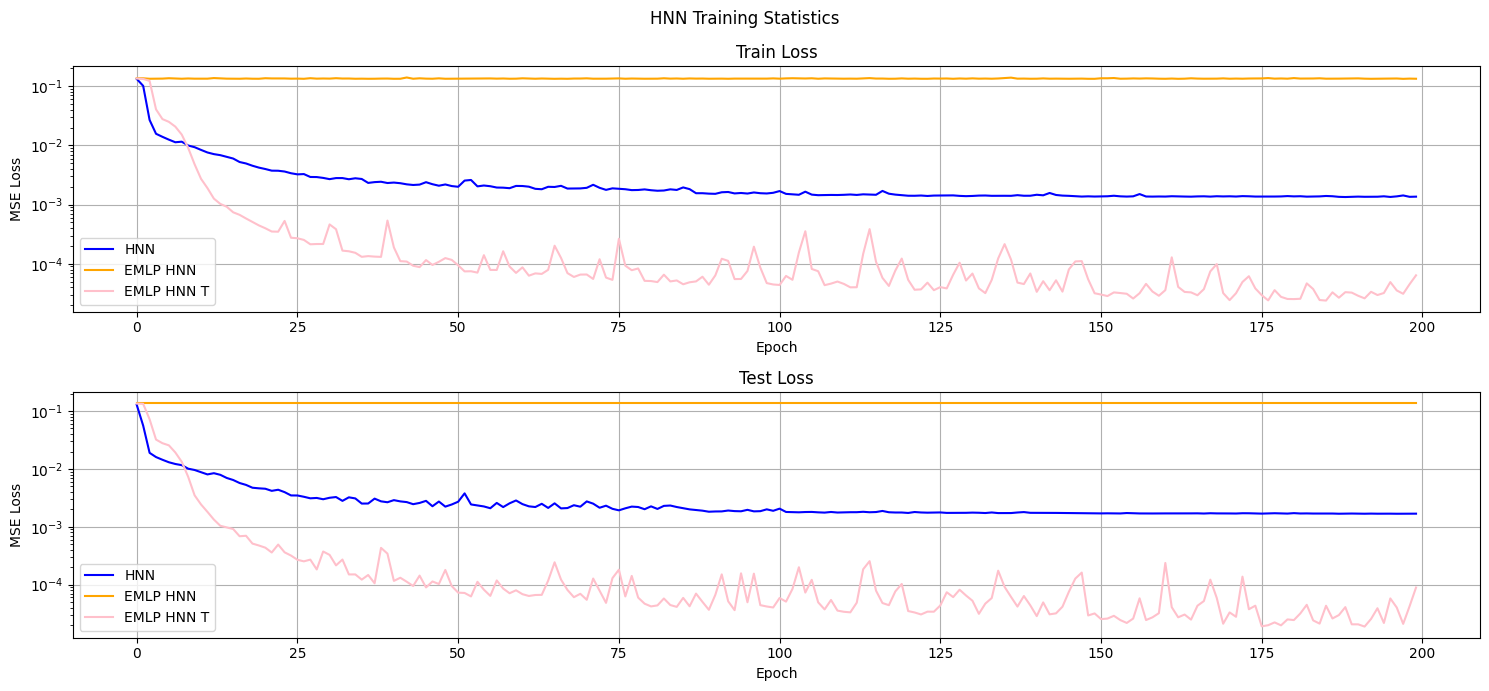

In [16]:
# Plot training statistics
plt.figure(figsize=(15, 7))

plt.subplot(2, 1, 1)
plt.plot(stats_hnn['train_loss'],label='HNN',color='blue')
plt.plot(stats_hnn_emlp['train_loss'],label='EMLP HNN',color='orange')
plt.plot(stats_hnn_emlp_t['train_loss'],label='EMLP HNN T',color='pink')

plt.yscale('log')
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(stats_hnn['test_loss'],label='HNN',color='blue')
plt.plot(stats_hnn_emlp['test_loss'],label='EMLP HNN',color='orange')
plt.plot(stats_hnn_emlp_t['test_loss'],label='EMLP HNN T',color='pink')


plt.yscale('log')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.suptitle('HNN Training Statistics')
plt.tight_layout()
plt.show()

In [17]:
# Test the HNN model on a specific initial condition 

print("\nSimulating with trained HNN...")
initial_state = initial_state = test_coords[-1,0,:]


# DEBUG: Check that the HNN gives reasonable derivatives at the initial state
initial_tensor = torch.tensor([initial_state], dtype=torch.float32)
initial_tensor.requires_grad_(True)
# Simulate using trained HNN
t_hnn, y_hnn = simulate_hnn(model_hnn, initial_state, (0, 10)) 





Simulating with trained HNN...


In [18]:
# Test the EMLP HNN model on a specific initial condition  

print("\nSimulating with trained EMLP HNN using discovered symmetries ...") 

initial_state = test_coords[-1,0,:]

t_hnn_emlp, y_hnn_emlp = simulate_hnn_emlp_gpu(model_hnn_emlp,initial_state,t_span=[0,10],num_points=1000,debug=True)


Simulating with trained EMLP HNN using discovered symmetries ...
Starting GPU simulation with initial state: [-1.2666498   0.          1.2666498   0.          0.00942552  0.3382114
 -0.00904748 -0.33986762]
JAX device: [CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3)]
Initial derivatives: [[ 0.  0.  0.  0. -0. -0. -0. -0.]]
GPU integration completed successfully
Solution shape: (8, 1000)


In [19]:
# Test the EMLP HNN model on a specific initial condition  

print("\nSimulating with trained EMLP HNN using original symmetries ...") 

initial_state = test_coords[-1,0,:]

t_hnn_emlp_t, y_hnn_emlp_t = simulate_hnn_emlp_gpu(model_hnn_emlp_t,initial_state,t_span=[0,10],num_points=1000,debug=True)


Simulating with trained EMLP HNN using original symmetries ...
Starting GPU simulation with initial state: [-1.2666498   0.          1.2666498   0.          0.00942552  0.3382114
 -0.00904748 -0.33986762]
JAX device: [CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3)]
Initial derivatives: [[ 7.3016509e-03  3.4784049e-01 -7.8369007e-03 -3.4694603e-01
   1.5923385e-01 -1.7725769e-04 -1.5710913e-01  8.5074641e-04]]
GPU integration completed successfully
Solution shape: (8, 1000)


In [20]:
from Data.two_body_dataset import TwoBodySimulator

print('\nSimulating with the original simulator') 

sim = TwoBodySimulator(
    G = metadata['G'],
    m1 = metadata['m1'],
    m2 = metadata['m2']
)


t_sim, y_sim = sim.simulate(initial_state=initial_state,t_span=[0,10])

# y_sim[:,1] = y_sim[:,1] * (metadata['m1']*metadata['m2'])/(metadata['m1']+metadata['m2'])


Simulating with the original simulator


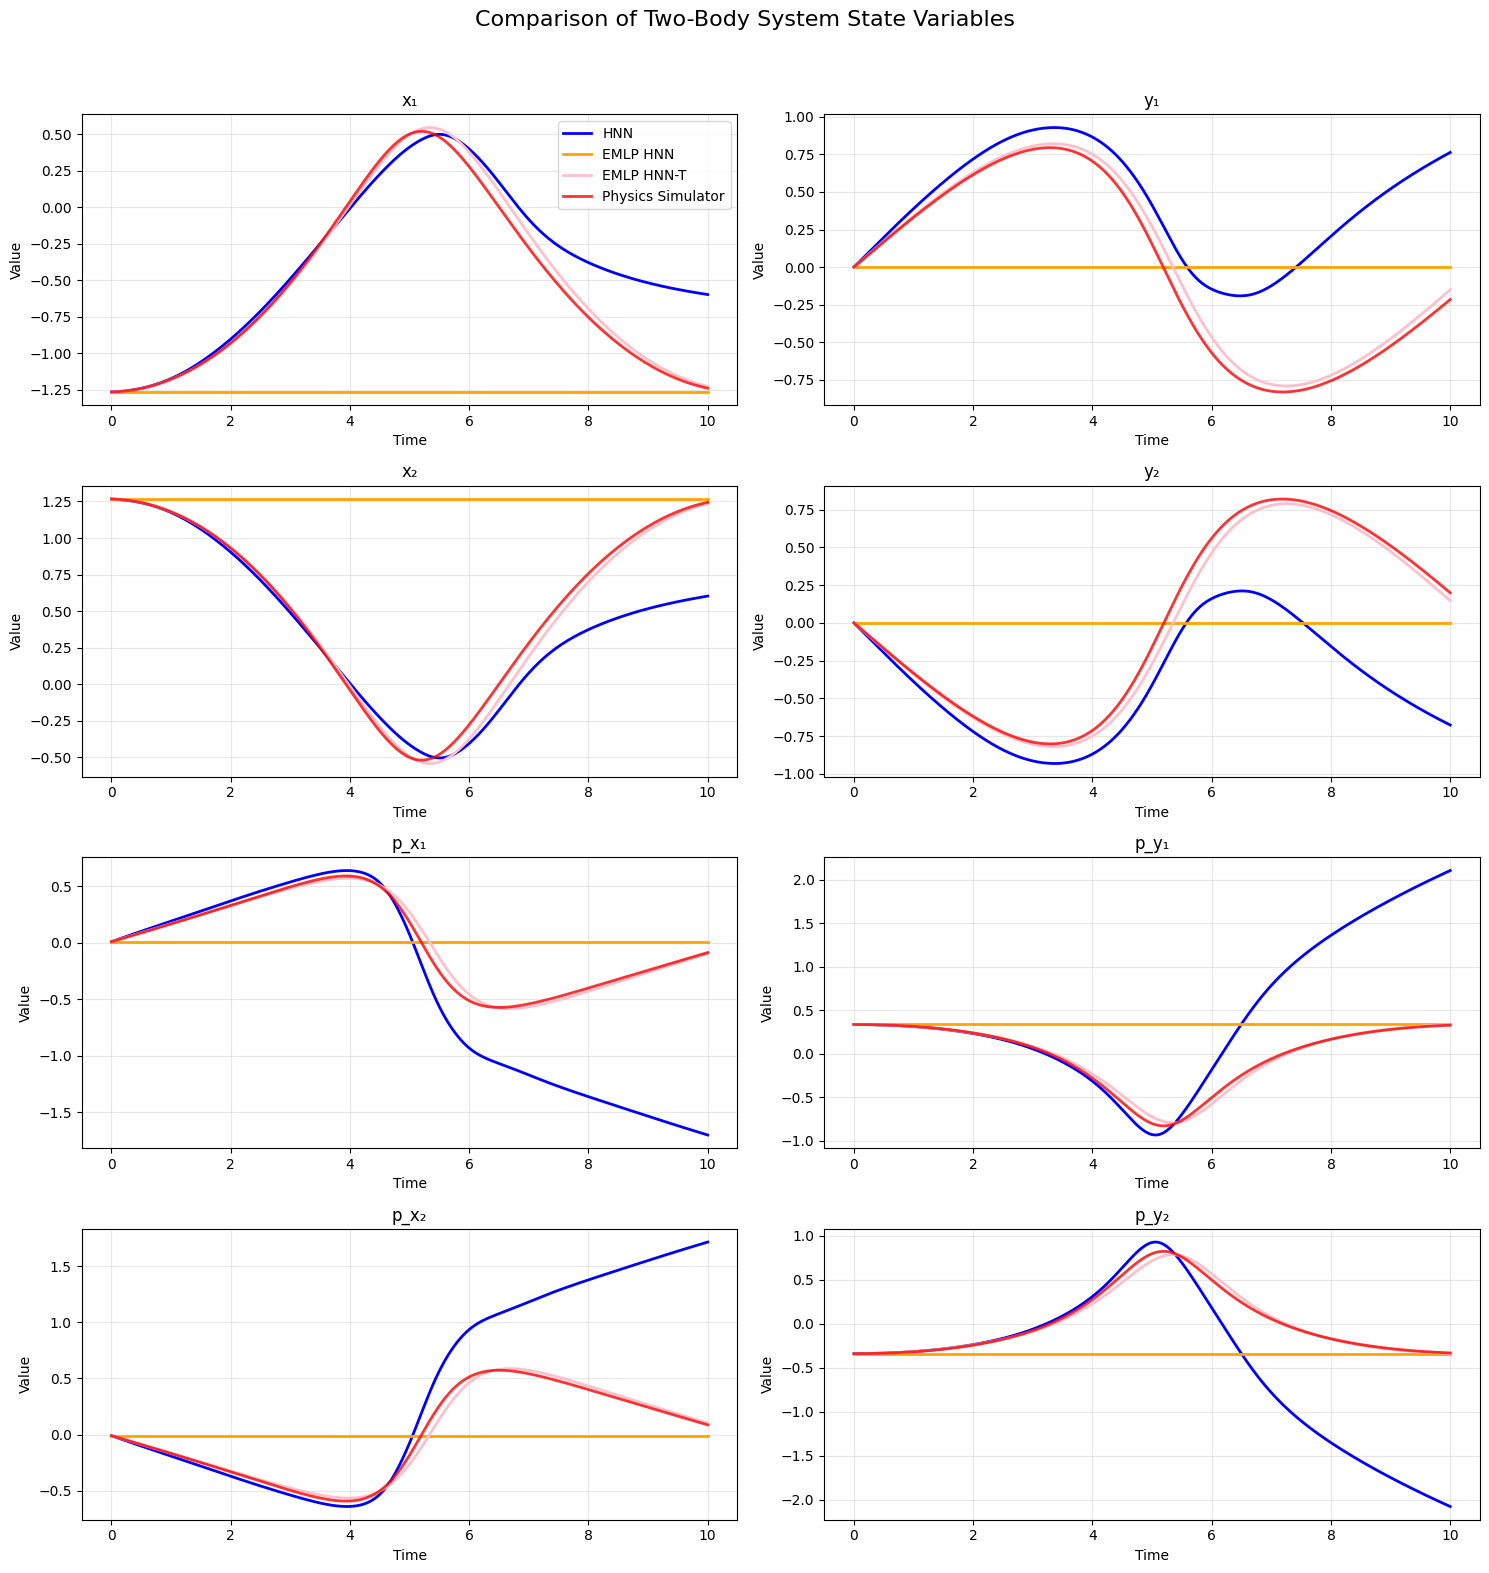

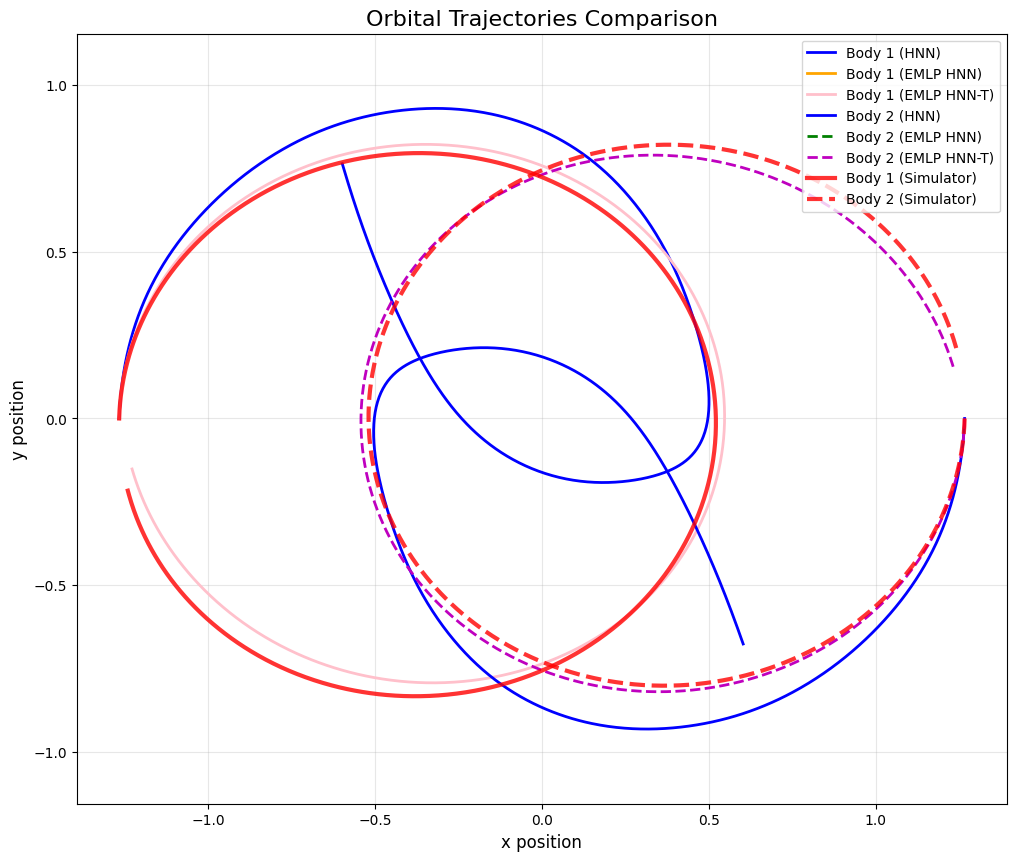

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def plot_all_variables(y_hnn, y_hnn_emlp, y_hnn_emlp_t, y_sim, time_steps=None):
    """
    Plot all 8 variables from four different models for comparison.
    
    Parameters:
    -----------
    y_hnn : array, shape (8, 1000)
        Prediction from standard HNN model
    y_hnn_emlp : array, shape (8, 1000) 
        Prediction from EMLP-HNN model
    y_hnn_emlp_t : array, shape (8, 1000)
        Prediction from second EMLP-HNN model (e.g., transformed or different variant)
    y_sim : array, shape (100, 8)
        Ground truth from physics simulator
    time_steps : array or None
        Time points for x-axis. If None, uses array indices
    """
    # Create time axes (they might be different lengths)
    if time_steps is None:
        t_hnn = np.arange(y_hnn.shape[1])
        t_emlp = np.arange(y_hnn_emlp.shape[1])
        t_emlp_t = np.arange(y_hnn_emlp_t.shape[1])
        t_sim = np.arange(y_sim.shape[0])
    else:
        # Use provided time steps with appropriate slicing
        t_hnn = time_steps[:y_hnn.shape[1]]
        t_emlp = time_steps[:y_hnn_emlp.shape[1]]
        t_emlp_t = time_steps[:y_hnn_emlp_t.shape[1]]
        t_sim = time_steps[:y_sim.shape[0]]
    
    # Variable names for labels
    var_names = ['x₁', 'y₁', 'x₂', 'y₂', 'p_x₁', 'p_y₁', 'p_x₂', 'p_y₂']
    
    # Create a 4x2 grid of subplots
    fig, axes = plt.subplots(4, 2, figsize=(15, 16))
    fig.suptitle('Comparison of Two-Body System State Variables', fontsize=16)
    
    # Plot all 8 variables
    for i, ax in enumerate(axes.flat):
        # Check shapes to ensure we're plotting correctly
        if y_hnn.shape[0] == 8:  # If first dimension is variables (8, 1000)
            ax.plot(t_hnn, y_hnn[i], 'blue', label='HNN', linewidth=2)
            ax.plot(t_emlp, y_hnn_emlp[i], 'orange', label='EMLP HNN', linewidth=2)
            ax.plot(t_emlp_t, y_hnn_emlp_t[i], 'pink', label='EMLP HNN-T', linewidth=2)
        else:  # If transposed (1000, 8)
            ax.plot(t_hnn, y_hnn[:, i], 'blue', label='HNN', linewidth=2)
            ax.plot(t_emlp, y_hnn_emlp[:, i], 'orange', label='EMLP HNN', linewidth=2)
            ax.plot(t_emlp_t, y_hnn_emlp_t[:, i], 'pink', label='EMLP HNN-T', linewidth=2)
        
        # Plot simulator data (ground truth)
        ax.plot(t_sim, y_sim[:, i], 'red', label='Physics Simulator', linewidth=2, alpha=0.8)
        
        ax.set_title(f'{var_names[i]}', fontsize=12)
        ax.set_xlabel('Time', fontsize=10)
        ax.set_ylabel('Value', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Only add legend to the first plot to save space
        if i == 0:
            ax.legend(fontsize=10)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for suptitle
    
    # Plot orbital trajectories of both bodies
    plt.figure(figsize=(12, 10))
    plt.title('Orbital Trajectories Comparison', fontsize=16)
    
    # Body 1 trajectories
    if y_hnn.shape[0] == 8:
        plt.plot(y_hnn[0], y_hnn[1], 'blue', label='Body 1 (HNN)', linewidth=2)
        plt.plot(y_hnn_emlp[0], y_hnn_emlp[1], 'orange', label='Body 1 (EMLP HNN)', linewidth=2)
        plt.plot(y_hnn_emlp_t[0], y_hnn_emlp_t[1], 'pink', label='Body 1 (EMLP HNN-T)', linewidth=2)
        
        # Body 2 trajectories
        plt.plot(y_hnn[2], y_hnn[3], 'blue', label='Body 2 (HNN)', linewidth=2)
        plt.plot(y_hnn_emlp[2], y_hnn_emlp[3], 'g--', label='Body 2 (EMLP HNN)', linewidth=2)
        plt.plot(y_hnn_emlp_t[2], y_hnn_emlp_t[3], 'm--', label='Body 2 (EMLP HNN-T)', linewidth=2)
    else:
        plt.plot(y_hnn[:, 0], y_hnn[:, 1], 'b-', label='Body 1 (HNN)', linewidth=2)
        plt.plot(y_hnn_emlp[:, 0], y_hnn_emlp[:, 1], 'g-', label='Body 1 (EMLP HNN)', linewidth=2)
        plt.plot(y_hnn_emlp_t[:, 0], y_hnn_emlp_t[:, 1], 'm-', label='Body 1 (EMLP HNN-T)', linewidth=2)
        
        # Body 2 trajectories
        plt.plot(y_hnn[:, 2], y_hnn[:, 3], 'b--', label='Body 2 (HNN)', linewidth=2)
        plt.plot(y_hnn_emlp[:, 2], y_hnn_emlp[:, 3], 'g--', label='Body 2 (EMLP HNN)', linewidth=2)
        plt.plot(y_hnn_emlp_t[:, 2], y_hnn_emlp_t[:, 3], 'm--', label='Body 2 (EMLP HNN-T)', linewidth=2)
    
    # Simulator trajectories (ground truth)
    plt.plot(y_sim[:, 0], y_sim[:, 1], 'r-', label='Body 1 (Simulator)', linewidth=3, alpha=0.8)
    plt.plot(y_sim[:, 2], y_sim[:, 3], 'r--', label='Body 2 (Simulator)', linewidth=3, alpha=0.8)
    
    plt.xlabel('x position', fontsize=12)
    plt.ylabel('y position', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.legend(fontsize=10, loc='best')
    
    plt.show()

plot_all_variables(y_hnn,y_hnn_emlp, y_hnn_emlp_t, y_sim, t_sim)

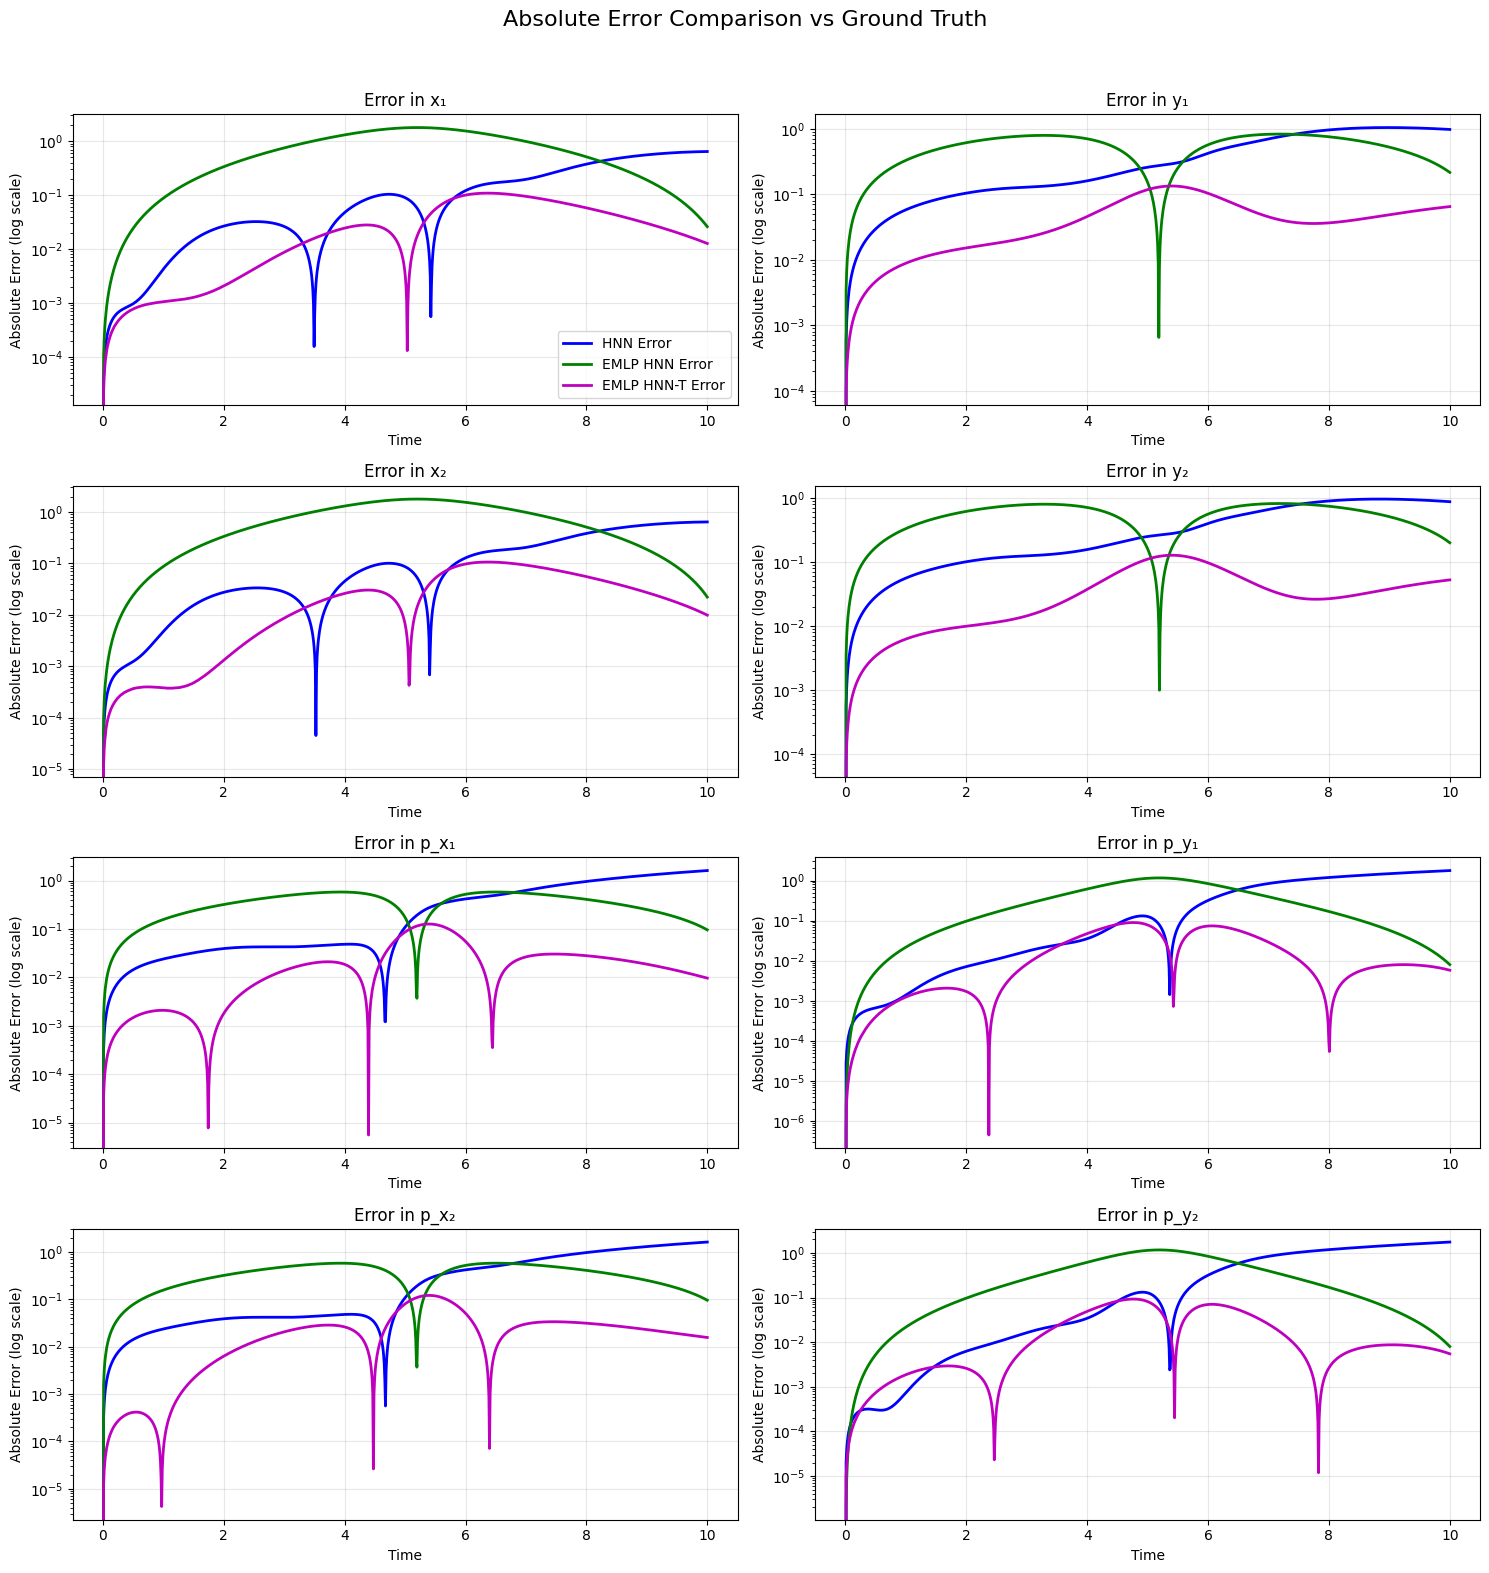

In [22]:
def plot_error_comparison(y_hnn, y_hnn_emlp, y_hnn_emlp_t, y_sim, time_steps=None):
    """
    Plot error comparison between different models and ground truth.
    
    Parameters:
    -----------
    y_hnn : array, shape (8, 1000)
        Prediction from standard HNN model
    y_hnn_emlp : array, shape (8, 1000) 
        Prediction from EMLP-HNN model
    y_hnn_emlp_t : array, shape (8, 1000)
        Prediction from second EMLP-HNN model
    y_sim : array, shape (100, 8)
        Ground truth from physics simulator
    time_steps : array or None
        Time points for x-axis. If None, uses array indices
    """
    # Interpolate simulator data to match model predictions length
    min_length = min(y_hnn.shape[1], y_hnn_emlp.shape[1], y_hnn_emlp_t.shape[1])
    
    if time_steps is None:
        t_plot = np.arange(min_length)
    else:
        t_plot = time_steps[:min_length]
    
    # Interpolate y_sim to match the length
    from scipy.interpolate import interp1d
    t_sim_orig = np.linspace(0, len(y_sim)-1, len(y_sim))
    t_sim_new = np.linspace(0, len(y_sim)-1, min_length)
    
    y_sim_interp = np.zeros((min_length, 8))
    for i in range(8):
        f = interp1d(t_sim_orig, y_sim[:, i], kind='linear', fill_value='extrapolate')
        y_sim_interp[:, i] = f(t_sim_new)
    
    # Calculate errors
    if y_hnn.shape[0] == 8:  # If first dimension is variables
        error_hnn = np.abs(y_hnn[:, :min_length].T - y_sim_interp)
        error_emlp = np.abs(y_hnn_emlp[:, :min_length].T - y_sim_interp)
        error_emlp_t = np.abs(y_hnn_emlp_t[:, :min_length].T - y_sim_interp)
    else:  # If transposed
        error_hnn = np.abs(y_hnn[:min_length, :] - y_sim_interp)
        error_emlp = np.abs(y_hnn_emlp[:min_length, :] - y_sim_interp)
        error_emlp_t = np.abs(y_hnn_emlp_t[:min_length, :] - y_sim_interp)
    
    # Variable names for labels
    var_names = ['x₁', 'y₁', 'x₂', 'y₂', 'p_x₁', 'p_y₁', 'p_x₂', 'p_y₂']
    
    # Create error plots
    fig, axes = plt.subplots(4, 2, figsize=(15, 16))
    fig.suptitle('Absolute Error Comparison vs Ground Truth', fontsize=16)
    
    for i, ax in enumerate(axes.flat):
        ax.semilogy(t_plot, error_hnn[:, i], 'b-', label='HNN Error', linewidth=2)
        ax.semilogy(t_plot, error_emlp[:, i], 'g-', label='EMLP HNN Error', linewidth=2)
        ax.semilogy(t_plot, error_emlp_t[:, i], 'm-', label='EMLP HNN-T Error', linewidth=2)
        
        ax.set_title(f'Error in {var_names[i]}', fontsize=12)
        ax.set_xlabel('Time', fontsize=10)
        ax.set_ylabel('Absolute Error (log scale)', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        if i == 0:
            ax.legend(fontsize=10)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_error_comparison(y_hnn, y_hnn_emlp, y_hnn_emlp_t, y_sim, t_sim)

In [23]:
## Computing Error metrics 

n = 10  # Number of samples
indices = np.random.choice(test_coords.shape[0], min(n,test_coords.shape[0]), replace=False)

def mse_comp(arr1,arr2):
    assert arr1.shape == arr2.shape 

    squared_diff = (arr1-arr2)**2 
    return np.mean(squared_diff)

mse = {
    'HNN':[],
    'EMLP_HNN':[], 
    'EMLP_HNN_T':[],
}

for idx in indices:
    initial_state = test_coords[idx,0,:]

    _, y_hnn = simulate_hnn(model_hnn, initial_state, (0, 10)) 
    _, y_hhn_emlp = simulate_hnn_emlp_gpu(model_hnn_emlp,initial_state,t_span=[0,10])
    _, y_hhn_emlp_t = simulate_hnn_emlp_gpu(model_hnn_emlp_t,initial_state,t_span=[0,10])

    _, y_sim = sim.simulate(initial_state=initial_state,num_points=1000,t_span=[0,10])

    y_sim = y_sim.T 



    mse['EMLP_HNN'].append(mse_comp(y_sim,y_hhn_emlp))
    mse['EMLP_HNN_T'].append(mse_comp(y_sim,y_hhn_emlp_t))
    mse['HNN'].append(mse_comp(y_sim,y_hnn))

In [24]:
for k in mse.keys():
    print(f'{k} : {np.mean(mse[k])}')

HNN : 0.16686726988846973
EMLP_HNN : 0.5938254594802856
EMLP_HNN_T : 0.009192870929837227


: 